# SoS actions, targets, and functions


## SoS Action

Although arbitrary python functions can be used in SoS step process, SoS defines many special functions called **`actions`** that accepts some shared parameters, and can behave differently in different modes of SoS.

For example, function `time.sleep(5)` would be executed in run mode,

In [1]:
%run
[0]
import time
st = time.time()
time.sleep(1)
print('I just slept {:.2f} seconds'.format(time.time() - st))

I just slept 1.01 seconds


and also in dryrun mode (option `-n`),

In [2]:
%run -n
[0]
import time
st = time.time()
time.sleep(1)
print('I just slept {:.2f} seconds'.format(time.time() - st))

I just slept 1.00 seconds


because these statements are regular Python functions. However, if you put the statements in an action `python`, the statements would be executed in run mode,

In [3]:
%run
[0]
python:
    import time
    st = time.time()
    time.sleep(1)
    print('I just slept {:.2f} seconds'.format(time.time() - st))

I just slept 1.00 seconds


but will print out the script it would execute in dryrun mode (option `-n`)

In [4]:
%run -n
[0]
python:
    import time
    st = time.time()
    time.sleep(1)
    print('I just slept {:.2f} seconds'.format(time.time() - st))

python:
import time
st = time.time()
time.sleep(1)
print('I just slept {:.2f} seconds'.format(time.time() - st))




## Action options

Actions define their own parameters but their execution is controlled by a common set of options.

###  `active`

Action option `active` is used to activate or inactivate an action in an input loop. It accept either a condition that returns a boolean variable (`True` or `False`), or one or more integers, or slices that corresponds to indexes of active substeps.

The first usage allows you to execute an action only if certain condition is met, so

```
if cond:
  action(param)
```

is equivalent to

```
action(param, active=cond)
```
or
```
action: active=cond
  param
```
in script format. For example, the following action will only be executed if `a.txt` exists

In [5]:
!echo "something" > a.txt

sh: active=path('a.txt').exists()
  echo `wc a.txt`


1 1 10 a.txt


For the second usage, when a loop is defined by `for_each` or `group_by` options of `input:` statement, an action after input would be repeated for each substep. The `active` parameter accepts an integer, either a non-negative number, a negative number (counting backward), a sequence of indexes, or a slice object, for which the action would be active.

For example, for an input loop that loops through a sequence of numbers, the first action `run` is executed for all groups, the second action is executed for even number of groups, the last action is executed for the last step.

In [6]:
seq = range(5)
input: for_each='seq'
run: expand=True
   echo I am active at all groups {_index}
run: active=slice(None, None, 2), expand=True
   echo I am active at even groups {_index}
run: active=-1, expand=True
   echo I am active at last group {_index}

echo I am active at all groups 0
I am active at all groups 0
echo I am active at even groups 0
I am active at even groups 0
echo I am active at all groups 1
I am active at all groups 1
echo I am active at all groups 2
I am active at all groups 2
echo I am active at even groups 2
I am active at even groups 2
echo I am active at all groups 3
I am active at all groups 3
echo I am active at all groups 4
I am active at all groups 4
echo I am active at even groups 4
I am active at even groups 4
echo I am active at last group 4
I am active at last group 4


### `allow_error`

Option `allow_error` tells SoS that the action might fail but this should not stop the workflow from executing. This option essentially turns an error to a warning message and change the return value of action to `None`. 

For example, in the following example, the wrong shell script would stop the execution of the step so the following action is not executed.

In [7]:
%sandbox --expect-error
run: 
    This is not shell
print('Step after run')

This is not shell
/var/folders/ys/gnzk0qbx5wbdgm531v82xxljv5yqy8/T/tmp61jtc31t.sh: line 1: This: command not found



---------------------------------------------------------------------------
RuntimeError                              Traceback (most recent call last)
script_-6007614678196007106 in <module>
      run(r"""This is not shell
----> """)
      print('Step after run')

RuntimeError: Failed to execute commmand "/bin/bash -ev /var/folders/ys/gnzk0qbx5wbdgm531v82xxljv5yqy8/T/tmp61jtc31t.sh" (ret=127, workdir=/private/var/folders/ys/gnzk0qbx5wbdgm531v82xxljv5yqy8/T/tmp6gu8uy4m, script now in /var/folders/ys/gnzk0qbx5wbdgm531v82xxljv5yqy8/T/tmp6gu8uy4m/.sos/scratch_0_0_e3a03a5f.sh)


but in this example, the error of `run` action is turned to a warning message and the later step would still be executed.

In [8]:
run: allow_error=True
    This is not shell
print('Step after run')

This is not shell
/var/folders/ys/gnzk0qbx5wbdgm531v82xxljv5yqy8/T/tmp9ldhoswt.sh: line 1: This: command not found


Step after run


###  `args`

All script-executing actions accept an option `args`, which changes how the script is executed.

By default, such an action has an `interpreter` (e.g. `bash`), a default `args='{filename:q}'`, and the script would be executed as `interpreter args`, which is
```
bash {filename:q}
```
where `{filename:q}` would be replaced by the script file created from the body of the action.

If you would like to change the command line with additional parameters, or different format of filename, you can specify an alternative `args`, with variables `filename` (filename of temporary script) and `script` (actual content of the script).

For example, option `-n` can be added to command `bash` to execute script in dryrun mode

In [8]:
bash: args='-n {filename:q}'
    echo "-n means running in dryrun mode (only check syntax)"

and you can actually execute a command without filename, and instead executing the script directly from command line

In [9]:
python: args='-m timeit {script}'
    '"-".join(str(n) for n in range(100))'

10000 loops, best of 3: 32.1 usec per loop


### `container` and `engine`

Parameter `container` and `engine` specify name or URL and execution engine of the container used to execute the action. Parameter `engine` is usually derived from `container` but can be specified explicitly as one of

* `engine='docker'`: Execute the script in specified container using [docker](https://www.docker.com/)
* `engine='singularity'`: Execute the script with [singularity](https://www.sylabs.io/)
* `engine='local'`: Execute the script locally, this is the default mode.

Parameters `container` and `engine` accept the following values:

| `container` | `engine` | execute by | example | comment | 
| -- | -- | -- | -- | -- |
| `tag` | ` `  | docker | `container='ubuntu'` | docker is the default container engine |
| `name` | `docker` | docker | `container='ubuntu', engine='docker'` | treat `name` as docker tag |
| `docker://tag` | ` ` | docker |  `container='docker://ubuntu'`  | |
| `filename.simg` | ` ` | singularity | `container='ubuntu.simg'` | |
| `shub://tag` | ` ` | singularity | `container='shub://GodloveD/lolcow'` | Image will be pulled to a local image |
| `name` | `singularity` | singularity | `container='a_dir', engine='singularity'` | treat `name` as singularity image file or directory |
| `docker://tag` | `singularity` | singularity |  `container='docker://godlovdc/lolcow', engine='singularity'`  |  |
| `file://filename` | ` ` | singularity | `container='file://ubuntu.simg'` | |
| `local://name` | ` ` | local | `container='local:any_tag'` | `local://any_tag` is equivalent to `engine='local'` |
| `name` | `local` | local | `engine=engine` with `parameter: engine='docker'` | Usually used to override parameter `container` |

Basically,
* `container='tag'` pulls and uses docker image `tag`
* `container='filename.simg` uses an existing singularity image
* `container='shub://tag'` pulls and uses singularity image `shub://tag`, which will generate a local `tag.simg` file

If a docker image is specified, the action is assumed to be executed in the specified docker container. The image will be automatically downloaded (pulled) if it is not available locally. 

For example, executing the following script 

```
[10]
python3: container='python'
  set = {'a', 'b'}
  print(set)
  ```

under a docker terminal (that is connected to the docker daemon) will

1. Pull docker image `python`,  which is the official docker image for Python 2 and 3.
2. Create a python script with the specified content
3. Run the docker container `python` and make the script available inside the container
4. Use the `python3` command inside the container to execute the script.

Additional `docker_run` parameters can be passed to actions when the action
is executed in a docker image. These options include

* `name`: name of the container (option `--name`)
* `tty`: if a tty is attached (default to `True`, option `-t`)
* `stdin_open`: if stdin should be open (default to `False`, option `-i`)
* `user`: username (default o `root`, option `-u`)
* `environment`: Can be a string, a list of string or dictinary of environment variables for docker (option `-e`)
* `volumes`: shared volumes as a string or list of strings, in the format of `hostdir` (for `hostdir:hostdir`) or `hostdir:mnt_dir`, in addition to current working directory which will always be shared.
* `volumes_from`: container names or Ids to get volumes from
* `port`: port opened (option `-p`)
* `extra_args`: If there is any extra arguments you would like to pass to the `docker run` process (after you check the actual command of `docker run` of SoS

Because of the different configurations of docker images, use of docker in SoS can be complicated. Please refer to http://vatlab.github.io/SOS/doc/tutorials/SoS_Docker_Guide.html for details.


### `docker_image` (deprecated)

In [ ]:
`docker_image='tag'` is now replaced with `container='tag'` or `container='docker://tag'` 

### `default_env`

Option `default_env` set environment variables **if they do not exist in the system**. The value of this option should be a dictionary with string keys and values.

### `docker_file` (deprecated)

This option allows you to import a docker from specified `docker_file`, which can be an archive file (`.tar`, `.tar.gz`, `.tgz`, `.bzip`, `.tar.xz`, `.txz`) or a URL to an archive file (e.g. `http://example.com/exampleimage.tgz`). SoS will use command `docker import` to import the `docker_file`. However, because SoS does not know the repository and tag names of the imported docker file, you will still need to use option `docker_image` to specify the image to use.

### `env`

Option `env` set environment variables **that overrides system variables defined in `os.environ`**. This option can be used to define `PATH` and other environmental variables for the action.

### `input`

Parameter `input` specifies the input files that an action needs before it can be executed. However, unlike targets in `input:` statement of a step where lacking an input target would trigger the execution of an auxiliary step (if needs) to produce it, SoS would yield an error if the input file does not exist.

For example, in the following example, step `20` is executed after step `10` so its `report` action can report the content of `a.txt` produced by step `10`.

In [10]:
%sandbox
%run
[10]
output: 'a.txt'
bash:
    echo 'content of a.txt' > a.txt

[20]
report: input='a.txt'

content of a.txt



However, in the following example, step `20` is executed as the first step of workflow `default`. The `report` action requires input file `a.txt` and yields an error.

In [11]:
%sandbox --expect-error
%run
[a: provides='a.txt']
bash:
    echo 'content of a.txt' > a.txt

[20]
report: input='a.txt'

ValueError: Input file a.txt does not exist.


`a.txt` has to be put into the input statement of step `20` for the auxiliary step to be executed:

In [12]:
%sandbox
%run
[a: provides='a.txt']
bash:
    echo 'content of a.txt' > a.txt

[20]
input: 'a.txt'
report: input=_input[0]

content of a.txt



Although all actions accept parameter `input` and SoS will always check the existence of specified input file, the action themselves might or might not make use of this parameter. Roughly speaking, script-executing actions such as `run`, `bash` and `python` accepts this parameter and prepend the content of all input files to the script; report-generation actions `report`, `pandoc` and `RMarkdown` append the content of input files after the specifie dscript, and other actions usually ignore this parameter.

For example, if you have a function that needs to be included in a Python script (more likely multiple scripts), you could define it in a separate file and include it with scripts defined in a `python` action: 

In [13]:
%run
# define a function and save to file myfunc.inc
report: output="myfunc.inc"
  def myfunc():
    print("Hello")

[1]
python: input='myfunc.inc'
    myfunc()

Hello


### `output`

Similar to `input`, parameter `output` defines the output of an action, which can be a single name (or target) or a list of files or targets. SoS would check the existence of output target after the completion of the action. For example, 

In [14]:
%sandbox --expect-error
%run
[10]
bash: output='non_existing.txt'

RuntimeError: Output target non_existing.txt does not exist after completion of action bash


In addition to checking the existence of input and output files, specifying `input` and `output` of an action will allow SoS to create signatures of action so that it will not be executed when it is called again with the same input and output files. This is in addition to step-level signature and can be useful for long-running actions.

For example, suppose action `sh` is time-consuming that produces output `test.txt`

In [15]:
%run -s default
[10]
import time, os
time.sleep(2)

sh: input=[], output='test.txt'
   touch test.txt

print(os.path.getmtime('test.txt'))


1512781007.0


Because the action has parameter `input` and `output`, a signature will be created so it will not be re-executed even when the step itself is changed (from `sleep(2)` to `sleep(1)`).

In [16]:
%run -s default
[10]
import time, os
time.sleep(1)

sh: input=[], output='test.txt'
   touch test.txt

print(os.path.getmtime('test.txt'))


1512781008.0


Note that we have to use option `-s default` for our examples because the default mode for SoS in Jupyter is `ignore` so no siguatures will be saved and used by default.

### `stdout`

Option `stdout` is applicable to script-executing actions such as `bash` and `R` and redirect the standard out of the action to specified file. The value of the option should be a path-like object (`str`, `path`, etc), or `False`. The file will be opened in `append` mode so you will have to remove or truncate the file if the file already exists. If `stdout=False`, the output will be suppressed (redirect to `/dev/null` under linux).

For example,

In [11]:
!rm -f test.log

sh: stdout='test.log'
ls *.ipynb

In [12]:
!head -2 test.log

Extending_SoS.ipynb
Language_Module.ipynb


### `stderr`

Option `stderr` is similar to `stdout` but redirects the standard error output of actions. `stderr=False` also suppresses stderr.

### `tracked`

If an action takes a long time to execute and the step it resides tend to be changed (for example, during the development of a workflow step), you might want to keep action-level signatures so that the action could be skipped if it has been executed before.

Action-level signature is controlled by parameter `tracked`, which can be `None` (no signature), `True` (record signature), `False` (do not record signature), a string (filename), or a list of filenames. When this parameter is `True` or one or more filenames, SoS will

1. if specified, collect targets specified by parameter `input`
2. if specified, colelct targets specified by parameter `output`
3. if one or more files are specified, collect targets from parameter `tracked`

These files, together with the content of the first parameter (usually a script), will be used to create a step signature and allow the actions with the same signature be skipped.

For example, suppose action `sh` is time-consuming that produces output `test.txt`

In [17]:
%run -s force
[10]
import time, os
time.sleep(2)

sh: output='test.txt', tracked=True
   touch test.txt

print(os.path.getmtime('test.txt'))


1512781011.0


Because of the `tracked=True` parameter, a signature will be created with `output` and it will not be re-executed even when the step itself is changed (from `sleep(2)` to `sleep(1)`).

In [18]:
%run -s default
[10]
import time, os
time.sleep(1)

sh: output='test.txt', tracked=True
   touch test.txt

print(os.path.getmtime('test.txt'))


INFO: Action sh is ignored due to saved signature


1512781011.0


Note that the signature can only be saved and used with appropriate signature mode (`force`, `default` etc).

### `workdir`

Option `workdir` changes the current working directory for the action, and change back once the action is executed. The directory will be created if it does not exist.

In [19]:
bash: workdir='tmp'
   touch a.txt
bash:
    ls tmp
    rm tmp/a.txt
    rmdir tmp

a.txt


## Core Actions

Let us start by listing all options for action `run` and compare it with actions `script` and `bash` before we dive into the details:

|action |condition | interpreter (configurable for `script`) | args (configurable) | command |comment|
|:--|:--|:-|:-|:-|:-|:-|
|`run`| `windows`|  | `{filename}` | `{filename}` |execute script directly as `.bat` file|
| | non-windows | `/bin/bash` | `-ev {filename}`| `/bin/bash -ev {filename}` | execute script by bash, print command and exit with error |
| | script with shebang line (`#!`) |  | `{filename}`| `{filename}` | execute script directly |
| |      |  `/bin/bash`   | `{script}` | `/bin/bash` content of  script | `script` as arguments of `/bin/bash` |
|`bash` | | `/bin/bash` | `{filename}`| `/bin/bash {filename}` | execute script as a bash script |
|`script`| |  | `{filename}` | `{filename}` | execute script directly |
|     | | `any_interpreter` | `{filename}` | `any {filename}` | execute with specified interpreter |
|    | | `any_interpreter` | `{script}` | `any_interpreter` content of script | execute content of script directly in command line|

Note that
1. All actions except `script` has fixed interpreter although action `run` uses different interpreter for different situations.
3. All actions accept configurable `args`, which can contain `{filename}` and `{script}` with `filename` being the name of the temporary script file, and `script` being the content of the script. In the latter case, the content of the script goes to the command line directly. It can of course contain any other fixed options.
3. If no interpreter is specified, the command will consist of only `args` so either the script file (if `args={filename}`) or the content of the script (if `args={script}`) is executed. SoS will make the script file executable in this case.
4. All script-executing actions except for `run` and `script` have fixed interpreters.


###  Action `run`

`run` is the most frequently used action in sos. In most cases, it is similar to action `bash` and uses `bash` to execute specified script. Under the hood, this action is quite different from `bash` because the run action does not have a default interpreter and would behave differently under different situations.

In the simplest case when one or more commands are specified, action `run` would assume it is a batch script under windows, and a bash script otherwise.

In [20]:
run:
    echo "A"

echo "A"
A


It is different from an `bash` action in that it will exit with error if any of the commands exits with non-zero code. That is to say, whereas a `sh` action would print an error message but continue as follows

In [21]:
sh:
    echoo "A"
    echo "B"

/var/folders/ys/gnzk0qbx5wbdgm531v82xxljv5yqy8/T/tmpzm7e7yc9.sh: line 1: echoo: command not found
B


The `run` action would exit with error

In [22]:
%sandbox --expect-error
run:
    echoo "A"
    echo "B"

echoo "A"
/var/folders/ys/gnzk0qbx5wbdgm531v82xxljv5yqy8/T/tmpzty1hljw.sh: line 1: echoo: command not found


RuntimeError: Failed to execute commmand ``/bin/bash /var/folders/ys/gnzk0qbx5wbdgm531v82xxljv5yqy8/T/tmp_j8ix8j1/.sos/scratch_0_0_4fbf16e8.sh`` (ret=127, workdir=/private/var/folders/ys/gnzk0qbx5wbdgm531v82xxljv5yqy8/T/tmp_j8ix8j1)


In another word,
```
run:
    command1
    command2
    command3
```
is equivalent to

```
bash:
    command1 && command2 && command3
```
under Linux/MacOS systems.

However, if the script starts with a shebang line, this action would execute the script directly. This allows you to execute any script in any language. For example, the following script executes a python script using action `run`

In [23]:
run:
    #!/usr/bin/env python
    print('This is python')

This is python


and the following example runs a complete sos script using command `sos-runner`

In [24]:
%run
# use sigil=None to stop interpolating expressions in script
[sos]
run:
    #!/usr/bin/env sos-runner
    [10]
    print(f"This is {step_name}")
    [20]
    print(f"This is {step_name}")

INFO: Executing default_10: 
INFO: input:   []
This is default_10
INFO: output:   []
INFO: Executing default_20: 
INFO: input:   []
This is default_20
INFO: output:   []
INFO: Workflow default (ID=9668068c46c0e2c0) is executed successfully.


Note that action `run`would not analyze shebang line of a script if it is executed in a docker container (with option `docker-image`) and would always assumed to be `bash`.

### Action `script`

Action `script` is the general form of all script-executing actions in SoS. It accepts a script, and parameters `interpreter` (required), `suffix` (if required by the interpreter) and optional `args` (command line arguments). It can be used to execute any script for which its interpreter is not currently supported by SoS. For example, the action

```
python:
    print('HERE')
```

can be executed as

In [25]:
script: interpreter='python'
    print('HERE')

HERE


###  Action `sos_run`

Action `sos_run(workflow=None, targets=None, shared=[], source=None, args={}, **kwargs)` executes a specified workflow from the current (default) or specified SoS script (`source`). The workflow can be a single workflow, a subworkflow (e.g. `A_-10`), a combined workflow (e.g. `A + B`), or a workflow that is constructed to generate `targets`. The workflow

* Takes `_input` of the parental step as the input of the first step of the subworkflow
* Takes `args` (a dictionary) and `**kwargs` as parameters as if they are specified from command line
* Copies variables specified in `shared` (a string or a list of string) to the subworkflow if they exist in the parental namespace
* Returns variables defined in `shared` to the parental namespace after the completion of the workflow

`sos_run` would be executed in a separate process in batch mode, and would be executed in the same process in interactive mode, so parameter `shared` is only needed for batch execution.

The simplest use of action `sos_run` is for the execution of one or more workflows. For example,

In [26]:
%run
[A]
print(step_name)

[B]
print(step_name)

[default]
sos_run('A + B')

A_0
B_0


The subworkflows are executed separately and only takes the `_input` of the step as the `input` of the workflow. For example,

In [27]:
%sandbox
%run
!touch a.txt b.txt

[process]
print(f"Handling {_input}")

[default]
input: 'a.txt', 'b.txt', group_by=1
sos_run('process')

Handling a.txt
Handling b.txt


If you would like to send one or more variables to the subworkflow or return a variable from the execution of subworkflow, you can specify them with the `shared` variable. The return variable part is a bit tricky here because you can only return workflow level variable that are usually `shared` from a step of the subworkflow. For example,

In [28]:
%sandbox
%run

[process]
print(f"Working with seed {seed}")

[default]
for seed in range(5):
    sos_run('process', seed=seed)

Working with seed 0
Working with seed 1
Working with seed 2
Working with seed 3
Working with seed 4


In [29]:
%sandbox
%run

[process: shared='result']
result = 100

[default]
sos_run('process')
print(f"Result from subworkflow process is {result}")
    

Result from subworkflow process is 100


If the subworkflow accepts parameters, they can be specified using keyword arguments or as a dictionary for parameter `args` of the `sos_run` function. The subworkflow would take values from parameters as if they are passed from command line. 

For example, the following workflow defines parameter `cutoff` with default value 10. When it is executed without command line option, the default value is used.

In [30]:
%sandbox
%run

[default]
parameter: cutoff=10
print(f"Process with cutoff={cutoff}")

[batch]
for value in range(2, 10, 2):
    sos_run('default', cutoff=value)

Process with cutoff=10


Command line argument could be used to specify a different `cutoff` value:

In [31]:
%sandbox
%rerun --cutoff 4

Process with cutoff=4


Now, if we run the `batch` workflow, which calls the `default` workflow with parameter `cutoff`, the `parameter: cutoff=10` statement takes the passed value as if it were specified from command line.

In [32]:
%sandbox
%rerun batch

Process with cutoff=2
Process with cutoff=4
Process with cutoff=6
Process with cutoff=8


Note that the parameters could also be specified with parameter `args`, 

In [33]:
%sandbox
%run batch

[default]
parameter: cutoff=10
print(f"Process with cutoff={cutoff}")

[batch]
for value in range(2, 10, 2):
    sos_run('default', args={'cutoff': value})

Process with cutoff=2
Process with cutoff=4
Process with cutoff=6
Process with cutoff=8


although the keyword arguments are usually easier to use.

Action `sos_run` cannot be used in `task` (see [Remote Execution](Remote_Execution.html) for details) because tasks are designed to be executed independently of the workflow. 

### Action `report`

Action `report` writes some content to an output stream. The input can either be a string or content of one or more files specified by option `input`. The output is determined by parameter `output`, and command line option `-r`.

* If `output='filename'`, the content will be written to a file.
* If `output=obj` and `obj` has a `write` function (e.g. a file handle), the content will be passed to the `write` function
* If output is unspecified and no filename is specified from option `-r`, the content will be written to standard output.
* If output is unspecified and a filename is specified with option `-r`, the content will be appended to specified file.

For example, the content of `report` actions is printed to standard output if no output is specified.

In [34]:
%run

[10]
report: expand=True
    Runing {step_name}

[20]
report: expand=True
    Runing {step_name}


Runing default_10

Runing default_20



We can specify an output file with option `output`, but the output will be overwritten if multiple actions write to the same file

In [35]:
%sandbox

%preview report.txt
%run
[10]
report: output='report.txt', expand=True
    Runing {step_name}

[20]
report: output='report.txt', expand=True
    Runing {step_name}

Action `report` can also take the content of one or more input files and write them to the output stream, after the script content (if specified). For example, the `report` action in the following example writes the content of `out.txt` to the default report stream (which is the standard output in this case).

In [36]:
%sandbox
%run

[10]
output: 'out.txt'
run:
   # run some command and generate a out.txt
   echo "* some result " > out.txt

[20]
report: input='out.txt'
Summary Report:

# run some command and generate a out.txt
echo "* some result " > out.txt

Summary Report:

* some result



### Action  `bash`

Action `bash(script)` accepts a shell script and execute it using `bash`. `sh`, `csh`, `tcsh`, `zsh` uses respective shell to execute the provided script.

These actions, as well as all script-executing actions such as `python`, also accept an option `args` and allows you to pass additional arguments to the interpreter. For example

In [37]:
run: args='-n {filename:q}'
      echo "a"

execute the script with command `bash -n` (check syntax), so command `echo` is not actually executed.

### Action `sh`
Execute script with a `sh` interpreter

### Action  `csh`
Execute script with a `csh` interpreter

### Action  `tcsh`
Execute script with a `tcsh` interpreter

###  Action `zsh`
Execute script with a `zsh` interpreter

### Action  `perl`

Action `perl(script)` execute the passed script using `perl` interpreter.

In [38]:
perl:
    my $name = "Brian";
    print "Hello, $name!\n";

Hello, Brian!


### Action  `ruby`

Action `ruby(script)` execute the passed script using `ruby` interpreter.

In [39]:
ruby:
    a = [ 45, 3, 19, 8 ]
    b = [ 'sam', 'max', 56, 98.9, 3, 10, 'jill' ]
    print (a + b).join(' '), "\n"
    print a[2], " ", b[4], " ", b[-2], "\n"
    print a.sort.join(' '), "\n"
    a << 57 << 9 << 'phil'
    print "A: ", a.join(' '), "\n"

45 3 19 8 sam max 56 98.9 3 10 jill
19 3 10
3 8 19 45
A: 45 3 19 8 57 9 phil


###  Action  `node`

Action `node(script)` executes the passed script using `node` (JavaScript) interpreter.

In [ ]:
node:
    var i, a, b, c, max;

    max = 1000000000;

    var d = Date.now();

    for (i = 0; i < max; i++) {
        a = 1234 + 5678 + i;
        b = 1234 * 5678 + i;
        c = 1234 / 2 + i;
    }

    console.log(Date.now() - d);

### Action  `pandoc`

Action `pandoc` uses command [pandoc](http://pandoc.org/) to convert specified input to output. This input to this action can be specified from option `script` (usually specified in script format) and `input`.

First, if a script is specified, pandoc assumes it is in markdown format and convert it by default to 'HTML' format. For example,

In [41]:
pandoc:
    # this is header
    This is some test, with **emphasis**.        

<h1 id="this-is-header">this is header</h1>
<p>This is some test, with <strong>emphasis</strong>.</p>


You can specify an output with option `output`

In [42]:
%sandbox
%preview out.html
pandoc: output='out.html'
    Itemize

    * item 1
    * item 2

INFO: Report saved to out.html


You can convert input file to another file type using a different file extension

In [43]:
%sandbox
%preview out.tex
pandoc: output='out.tex'
    Itemize

    * item 1
    * item 2

INFO: Report saved to out.tex


Or you can add more options to the command line by modifying `args`,

In [44]:
%sandbox
%preview out.html
pandoc: output='out.html', args='{input:q} --output {output:q} -s'
    Itemize

    * item 1
    * item 2

INFO: Report saved to out.html


The second usage of the `pandoc` action is to specify one or more input filenames. You have to use the function form of this action as follows

In [45]:
%sandbox
%preview out.html
[10]
report: output = 'out.md'
    Itemize

    * item 1
    * item 2

[20]
pandoc(input='out.md', output='out.html')
    

If multiple files are specified, the content of these input files will be concatenated. This is very useful for generating a single pandoc output with input from different steps. We will demonstrate this feature in the [Generating Reports](../tutorials/Generating_Reports.html) tutorial.

If both `script` and `input` parameters are specified, the content of input files would be appended to `script`. So

In [46]:
#%sandbox
%preview out.html
[10]
report: output = 'out10.md'
    Itemize

    * item 1
    * item 2

[20]
report: output= 'out20.md'
    enumerated

    1. item 1
    2. item 2

[30]
pandoc: input=['out10.md', 'out20.md'], output='out.html'
    Markdown supports both itemized and enumerated

### Action `docker_build`

Build a docker image from an inline Docker file. The inline version of the action currently does not support adding any file from local machine because the docker file will be saved to a random directory. You can walk around this problem by creating a `Dockerfile` and pass it to the action through option `path`. This action accepts all parameters as specified in [docker-py documentation](http://docker-py.readthedocs.io/en/latest/images.html) because SoS simply pass additional parameters to the `build` function.

For example, the following step builds a docker container for [MISO](http://miso.readthedocs.org/en/fastmiso/) based on anaconda python 2.7.

```
[build_1]
# building miso from a Dockerfile
docker_build: tag='mdabioinfo/miso:latest'

	############################################################
	# Dockerfile to build MISO container images
	# Based on Anaconda python
	############################################################

	# Set the base image to anaconda Python 2.7 (miso does not support python 3)
	FROM continuumio/anaconda

	# File Author / Maintainer
	MAINTAINER Bo Peng <bpeng@mdanderson.org>

	# Update the repository sources list
	RUN apt-get update

	# Install compiler and python stuff, samtools and git
	RUN apt-get install --yes \
	 build-essential \
	 gcc-multilib \
	 gfortran \ 
	 apt-utils \
	 libblas3 \ 
	 liblapack3 \
	 libc6 \
	 cython \ 
	 samtools \
	 libbam-dev \
	 bedtools \
	 wget \
	 zlib1g-dev \ 
	 tar \
	 gzip

	WORKDIR /usr/local
	RUN pip install misopy
```

### Action  `download`

Action `download(URLs, dest_dir='.', dest_file=None, decompress=False, max_jobs=5)` download files from specified URLs, which can be a list of URLs, or a string with tab, space or newline separated URLs. 

* If `dest_file` is specified, only one URL is allowed and the URL can have any form.
* Otherwise all files will be downloaded to `dest_dir`. Filenames are determined from URLs so the URLs must have the last portion as the filename to save. 
* If `decompress` is True, `.zip` file, compressed or plan `tar` (e.g. `.tar.gz`) files, and `.gz` files will be decompressed to the same directory as the downloaded file.
* `max_jobs` controls the maximum number of concurrent connection to **each domain** across instances of the `download` action. That is to say, if multiple steps from multiple workflows download files from the same website, at most `max_jobs` connections will be made. This option can therefore be used to throttle downloads to websites.

For example,

```
[10]
GATK_RESOURCE_DIR = '/path/to/resource'
GATK_URL = 'ftp://gsapubftp-anonymous@ftp.broadinstitute.org/bundle/2.8/hg19/'

download:   dest_dir=GATK_RESOURCE_DIR, expand=True
    {GATK_URL}/1000G_omni2.5.hg19.sites.vcf.gz
    {GATK_URL}/1000G_omni2.5.hg19.sites.vcf.gz.md5
    {GATK_URL}/1000G_omni2.5.hg19.sites.vcf.idx.gz
    {GATK_URL}/1000G_omni2.5.hg19.sites.vcf.idx.gz.md5
```

download the specified files to `GATK_RESOURCE_DIR`. The `.md5` files will be automatically used to validate the content of the associated files. Note that 

SoS automatically save signature of downloaded and decompressed files so the files will not be re-downloaded if the action is called multiple times. You can however still still specifies input and output of the step to use step signature


```
[10]
GATK_RESOURCE_DIR = '/path/to/resource'
GATK_URL = 'ftp://gsapubftp-anonymous@ftp.broadinstitute.org/bundle/2.8/hg19/'
RESOUCE_FILES =  '''1000G_omni2.5.hg19.sites.vcf.gz
    1000G_omni2.5.hg19.sites.vcf.gz.md5
    1000G_omni2.5.hg19.sites.vcf.idx.gz
    1000G_omni2.5.hg19.sites.vcf.idx.gz.md5'''.split() 
input: []
output:  [os.path.join(GATK_RESOURCE_DIR, x) for x in GATK_RESOURCE_FILES]
download([f'{GATK_URL}/{x}' for x in GATK_RESOURCE_FILES], dest=GATK_RESOURCE_DIR)
```

Note that the `download` action uses up to 5 processes to download files. You can change this number by adjusting system configuration `sos_download_processes`.

###  Action `fail_if`

Action `fail_if(expr, msg='')` raises an exception with `msg` (and terminate the execution of the workflow if the exception is not caught) if `expr` returns True.

###  Action `warn_if`

Action `warn_if(expr, msg)` yields a warning message `msg` if `expr` is evaluate to be true.

###  Action `stop_if`

Action `stop_if(expr, msg='')` stops the execution of the current step (or current iteration if within input loops specified by parameters `group_by` or `for_each`) and gives a warning message if `msg` is specified. For example,

In [47]:
%sandbox
%run
!touch a.txt
!echo 'something' > b.txt

[10]
input: '*.txt', group_by=1

stop_if(os.path.getsize(_input[0]) == 0)
print(_input)

b.txt


skips `a.txt` because it has size 0.

A side effect of `stop_if` is that it will clear `_output` of the iteration so that the step `output` consists of only files from non-stopped iterations. For example,

In [48]:
%sandbox
%run
[10]
input: for_each={'idx': range(10)}
output: f"{idx}.txt"
stop_if(idx % 2 == 0)
run: expand=True
    echo "Generating {_output}"
    touch {_output}

[20]
print(f"Output of last step is {input}")

echo "Generating 1.txt"
Generating 1.txt
touch 1.txt

echo "Generating 3.txt"
Generating 3.txt
touch 3.txt

echo "Generating 5.txt"
Generating 5.txt
touch 5.txt

echo "Generating 7.txt"
Generating 7.txt
touch 7.txt

echo "Generating 9.txt"
Generating 9.txt
touch 9.txt

Output of last step is Undetermined('')


## Core Targets

Targets are objects that a SoS step can input, output, or dependent on. They are usually files that are presented by filenames, but can also be other targets.

### Target `file_target`

Targets of type `file_target` represents files on a file system. The type ``file_target` should not be used explicitly because SoS treats string type targets as ``file_target`.

SoS uses md5 signature to detect changes of the content of files. To reduce the time to generate signature for large files, SoS extracts strips of data from large files to calculate partial MD5. The resulting signatures are different from md5 signature of complete files calcualted from other tools.

A file can be **zapped** by command `sos remove --zap` and still be considered available by SoS. This command removes a `file` and generates `{file}.zapped` with essential information such as signature and size of the original file. A step would not be rerun if its input, dependent, or output files are zapped instead of removed. This feature is useful for the removal of large intermediate files generated from the execution of workflows, whiling still keeping the complete runtime information of the workflow.

### Target `executable` 

In [49]:
`executable` targets are commands that should be accessible and executable by SoS. These targets are usually listed in the `depends` section of a SoS step. For example, SoS would stop if a command `fastqc` is not found.

%sandbox --expect-error
[10]
input:     'a.txt'
depends:   executable('some_command')
sh: expand=True
    some_command {input}

`executable` target can also be output of a step but installing executables can be tricky because the commands should be installed to existing `$PATH` so that they can be immediately accessible by SoS. Because SoS automatically adds `~/.sos/bin` to `$PATH` (option `-b`), an environment-neutral way for on-the-fly installation is to install commands to this directory. For example

!rm -f ~/.sos/bin/lls

[lls: provides=executable('lls')]
sh:
    echo "#!/usr/bin/env bash" > ~/.sos/bin/lls
    echo "echo I am lls" >> ~/.sos/bin/lls
    chmod +x ~/.sos/bin/lls

[10]
depends: executable('lls')
sh:
    lls

creates an executable command `lls` under `~/.sos/bin` when this executable does not exist.

You can also have finer control over which version of the command is eligible by checking the output of commands. The trick here is to provide a complete command and one or more version strings as the string that should appear in the output of the command.

For example, command `perl --version` is executed in the following example to check if the output contains string `5.18`. The step would only be executed if the right version exists.

[10]
depends: executable('perl --version', version='5.18')
print('ok')

If no verion string is provided, SoS will only check the existence of the command and not actually execute the command.

### Target `sos_variable` 

`sos_variable(name)` targets represent SoS variables that are created by a SoS step and shared to other steps. These targets can be used to provide information to other steps. For example,

In [50]:
%sandbox
[counts: shared='counts']
input: 'result.txt'
with open(input[0]) as ifile:
    counts = int(ifile.read())

[10]

# perform some task and create a file with some statistics
output: 'result.txt'
run:
   echo 100 >> result.txt 

[100]
depends: sos_variable('counts')
report: expand=True
    There are {counts} objects

Step `100` needed some information extracted from output of another step (step `10`). You can either parse the information in step `100` or use another step to provide the information. The latter is recommended because the information could be requested by multiple steps. Note that `counts` is an auxiliary step that provides `sos_variable('counts')` through its `shared` section option.

### Target `env_variable` 

SoS keeps tract of runtime environment and creates signatures of executed steps so that they do not have to be executed again. Some commands, especially shell scripts, could however behave differently with different environmental variables. To make sure a step would be re-executed with changing environments, you should list the variables that affects the output of these commands as dependencies of the step. For example

%sandbox --expect-error
[10]
depends:   env_variable('DEBUG')
sh:
    echo DEBUG is set to $DEBUG

### Target `sos_step` 

The `sos_step` target represents, needless to say, a SoS step. This target provides a straightforward method to specify step dependencies. For example,

In [51]:
%run
[init]
print("Initialize")

[10]
depends: sos_step("init")
print(f"I am {step_name}")

Initialize
I am default_10


What is more interesting, however, is that `sos_step('a')` matches to steps such as `a_1`, `a_2` so the step will depend on the execution of the entire workflow.

For example, in the following workflow, step `default` depends on `sos_step('work')`, which triggers a process-oriented workflow `work` with steps `work_1` and `work_2`.

> test.dot (859 B):

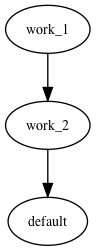

In [5]:
%preview -n test.dot
%run -d test.dot

[work_1]
# generate result
output: 'result.txt'
sh: expand=True
  echo some result > {_output}

[work_2]
# backup result
output: 'result.txt.bak'
sh: expand=True
  cp {_input} {_output}
  
[default]
depends: sos_step("work")

This example is similar to the following workflow that uses subworkflow (`sos_run('work')`) but as you can see from the generated DAG, the execution logics of the two are quite different. More specifically, the `sos_step()` target adds a subworkflow to the master DAG, while `sos_run` triggers a separate DAG. 

INFO: work_1 (index=0) is ignored due to saved signature
INFO: work_2 (index=0) is ignored due to saved signature


> test.dot (500 B):

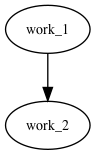

In [6]:
%preview -n test.dot
%run -d test.dot

[work_1]
# generate result
output: 'result.txt'
sh: expand=True
  echo some result > {_output}

[work_2]
# backup result
output: 'result.txt.bak'
sh: expand=True
  cp {_input} {_output}
  
[default]
sos_run("work")

### Target `dynamic` 

A `dynamic` target is a target that can only be determined when the step is actually executed. 

For example,

In [52]:
%sandbox --expect-error
[10]
output: '*.txt'
sh:
    touch a.txt

[20]
print(f'Last output is {input}')

To address this problem, you should try to expand the output file after the completion of the step, using a `dynamic` target.

In [53]:
%sandbox
[10]
output: dynamic('*.txt')
sh:
    touch a.txt

[20]
print(f"Last output is {input}")

Please refer to chapter [SoS Step](SoS_Step.html) for details of such targets.

### Target `remote`

A target that is marked as `remote` and would be instantiated only when it is executed by a task. Please check section [Remote Execution](Remote_Execution.html) for details.

### Target `system_resource`

Target `system_resource` checks the available system resource and is available only if the system has enough memory and/or diskspace for the workflow step. For example, the following step would generate an error if the system does not have at least `16G` of RAM and `1T` of disk space on the volume of the current project directory.

In [3]:
%run
[10]
depends: system_resource(mem='16G', disk='1T')
run:
   echo "some large job"

No step to generate target system_resource(mem='16G',disk='1T') requested by default_10


## Functions and objects

###  Function `get_output`

Function `get_output(cmd)` returns the output of command (decoded in `UTF-8`), which is a shortcut for `subprocess.check_output(cmd, shell=True).decode()`.

In [54]:
get_output('which ls')

'/bin/ls\n'

This function also accepts two options `show_command=False`, and `prompt='$ '` that can be useful in case you would like to present the command that produce the output. For example,

In [55]:
print(get_output('which ls', show_command=True))

$ which ls
/bin/ls



### Function  `expand_pattern`

Function `expand_pattern` expands a string to multiple ones using items of variables quoted between `{ }`. For example,

```python
output: expand_pattern('{a}_{b}.txt')
```

is equivalent to

```python
output: ['{x}_{y}.txt' for x,y in zip(a, b)]
```

if `a` and `b` are sequences of the same length. For example,

In [56]:
name = ['Bob', 'John']
salary = [200, 300]
expand_pattern("{name}'s salary is {salary}")

["Bob's salary is 200", "John's salary is 300"]

The sequences should have the same length

In [57]:
%sandbox --expect-error

salary = [200]
expand_pattern("{name}'s salary is {salary}")

ValueError: Undefined variable name in pattern {name}'s salary is {salary}


An exception is made for variables of simple non-sequence types, in which case they are repeated in all expanded items

In [58]:
salary = 200
expand_pattern("{name}'s salary is {salary}")

["Bob's salary is 200", "John's salary is 200"]

###  Object `logger`

The SoS logger object is a `logging` object used by SoS to produce various outputs. You can use this object to output error, warning, info, debug, and trace messages to terminal. For example,

In [59]:
%run -v2
[0]
logger.info(f"I am at {step_name}")

INFO: I am at default_0


The output of `logger` is controlled by logging level, for example, the above message would not be printed at `-v1` (warning)

In [60]:
%run -v1
[0]
logger.info(f"I am at {step_name}")

## Language JavaScript

### Action `node`

Action `node` execute specified JavaScript with command `node`.

## Language Julia

### Action `julia`

Action `julia` execute specified Julia script with command `julia`.

## Language Matlab

### Action `matlab`

Action `matlab` execute specified matlab script with default options `-nojvm -nodisplay -nosplash -r {filename:n};quit`. The options start matlab without desktop, execute the strip (with parameter without `.m` extension), and quit matlab when the script is completed.

## Language `Python`

### Action `python`

Action `python(script)` and `python3(script)` accepts a Python script and execute it with python or python3, respectively.

Because SoS can include Python statements directly in a SoS script, it is important to note that embedded Python
statements are interpreted by SoS and the `python` and `python3` actions are execute in separate processes without
access to the SoS environment.

For example, the following SoS step execute some python statements **within** SoS with direct access to SoS variables
such as `input`, and with `result` writing directly to the SoS environment,

```python
[10]
for filename in input:
    with open(filename) as data:
        result = filename + '.res'
        ....
```

while

```python
[10]
input: group_by='single'

python:

with open(${input!r}) as data:
   result = ${input!r} + '.res'
   ...


```

composes a Python script for each input file and calls separate Python interpreters to execute them. Whereas
the Python statement in the first example will always be executed, the statements in `python` will not be executed
in `inspect` mode.

### Action `python2`

Action `python2` is similar to `python` but it tries to use interpreter `python2` (or `python2.7` on some systems) before `python`, which could be python 3. Note that this action does not actually test the version of interpreter so it would use python 3 if this is the only available version.

### Action `python3`

Action `python3` is similar to `python` but it tries to use interpreter `python3` (version 3 of python) before `python`, which could be python 2. Note that this action does not actually test the version of interpreter so it would use python 2 if this is the only available version.

### Target `Py_Module`

This target is usually used in the `depends` statement of a SoS step to specify a required Python module. For example,

In [61]:
depends: Py_Module('tabulate')
from tabulate import tabulate
table = [["Sun",696000,1989100000],["Earth",6371,5973.6],
    ["Moon",1737,73.5],["Mars",3390,641.85]]
print(tabulate(table))

-----  ------  -------------
Sun    696000     1.9891e+09
Earth    6371  5973.6
Moon     1737    73.5
Mars     3390   641.85
-----  ------  -------------


If a module is not available, with `autoinstall=True` SoS will try to execute command `pip install` to install it, which might or might not succeed depending on your system configuration. For example,

```
Py_Module('numpy', autoinstall=True)
```

To specify version, 

```
Py_Module('numpy', version=">=1.14.0")
```

Or a shorthand syntax, 

```
Py_Module('numpy>1.14.0')
```

When module name is different from that used on `pypi`, eg, the package name is `scikit-learn` but module name is `sklearn`, then to allow for auto-install, use

```
Py_Module('sklearn', autoinstall='scikit-learn')
```

## Language `R`

### Action `R`

Action `R(script)` execute the passed script using `Rscript` command. 

In [62]:
R:
    D <- data.frame(x=c(1,2,3,1), y=c(7,19,2,2))
    # Sort on x
    indexes <- order(D$x)
    D[indexes,]

  x  y
1 1  7
4 1  2
2 2 19
3 3  2


### Action `Rmarkdown`

Action `Rmarkdown` shares the same user interface with action `pandoc`. The only big difference is that it used `R`'s `rmarkdown` package to render R-flavored Markdown language.

For example, the `Rmarkdown` action of the following example collects input files `A_10.md` and `A_20.md` and use `R`'s `rmarkdown` package to convert it to `out.html`.

In [63]:
%sandbox

[A_10]
report: output="A_10.md"
    step_10

[A_20]
report: output="A_20.md"
    Itemize

    * item 1
    * item 2

[A_30]
Rmarkdown(input=['A_10.md', 'A_20.md'], output='out.html')

### Target `R_library`

The `R_library` target represents a R library. If the libraries are not available, it will try to install it from [CRAN](https://cran.r-project.org/), [bioconductor](https://www.bioconductor.org/), or [github](https://github.com/). Github package name should be formatted as `pkg@path`. A typical usage of this target would be

In [64]:
%sandbox
[10]
output: 'test.jpg'
depends: R_library('ggplot2')
R: expand=True
  library(ggplot2) 
  jpeg({output!r})
  qplot(Sepal.Length, Petal.Length, data = iris, color = Species)
  dev.off()


`R_library` can also be used to check for specific versions of packages. For example:

```
R_library('edgeR', '3.12.0')
```
will result in a warning if edgeR version is not 3.12.0. You can specify multiple versions 

```
R_library('edgeR', ['3.12.0', '3.12.1'])
```

certain version or newer,
```
R_library('edgeR', '>=3.12.0')
```

certain version or older
```
check_R_library('ggplot2', '<1.0.0')
```

The default R library repo is `http://cran.us.r-project.org`. It is possible to customize the repo for which a R library would be installed, for example:

```
R_library('Rmosek', repos = "http://download.mosek.com/R/7")
```

To install from a github repository:

```
R_library('varbvs@pcarbo/varbvs/varbvs-R')
```
where `varbvs` is package name, `pcarbo/varbvs/varbvs-R` corresponds to sub-directory `varbvs-R` in repository `https://github.com/pcarbo/varbvs`.